# KIT Cube data from PC22

This notebook details the analysis for the LIDAR data from the Inn Valley. Note that some data preparation was performed separately from this notebook and thus the provided data will not match the publicly available data.

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import pandas as pd
import copy
import scipy
from scipy import signal as signal_processing
import glob
import numpy.ma as ma

# OS interaction
import os
import sys

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import DateFormatter
from pydmd.costs import COSTS
from pydmd.mrcosts import mrCOSTS
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt
import string
import matplotlib.gridspec as gridspec

# PyDMD can generate a huge number of warnings. We filter those here.
import warnings

warnings.filterwarnings("ignore")

# Get the path of the notebook. Re-running this cell will break the logic used.
dir_notebook = os.getcwd()

## Format plots

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = "paper"
sns.set_context(context)

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = [
    "#4477AA",
    "#CCBB44",
    "#EE6677",
    "#228833",
    "#66CCEE",
    "#AA3377",
    "#BBBBBB",
]
sns.set_palette(sns.color_palette(tol_bright_reorder))

alphabet = string.ascii_lowercase

## Directories

These should be amended to point towards where you have the data (`dir_KIT_data`), where you want the figures to go (`dir_print`), and where the mrCOSTS fits are stored (`dir_results`). You will need to run the notebook and fit mrCOSTS in order to generate the fitted model.

In [3]:
dir_KIT_data = os.path.join(dir_notebook, "data/KIT-cube")
dir_print = os.path.join(dir_notebook, "figures/KIT-cube")
dir_results = os.path.join(dir_notebook, "results/KIT-cube")

# Preparation

## Helper functions

In [4]:
def nan_cleaner(dvector, nfeatures, nsamples):
    """
    Return a matrix with the NaNs removed.
    """
    nandex_1d = np.nonzero(np.isnan(dvector))
    notnandex_1d = np.nonzero(~np.isnan(dvector))

    dvector = dvector[notnandex_1d]
    dvector = dvector.reshape(nfeatures, nsamples)

    return dvector

Unstacking the 1D spatial dimension using the xarray multiIndex framework (taken from here https://stackoverflow.com/questions/62592803/xarray-equivalent-of-np-reshape)

In [5]:
def xarray_unstacked(x, time, longitudes, latitudes):
    """
    Unstack data back to longitude by latitude.
    """
    ds_unstacked = xr.DataArray(
        x,
        coords={"time": time},
        dims=["xy", "time"],
    )

    ds_unstacked.coords["longitude"] = ("xy", longitudes.data)
    ds_unstacked.coords["latitude"] = ("xy", latitudes.data)
    ds_unstacked = ds_unstacked.set_index(xy=("latitude", "longitude")).unstack("xy")

    return ds_unstacked

In [6]:
def _unstack(x, ragged_lon, ragged_lat):
    """Unstack ragged dimensions without time"""

    ds_out = xr.DataArray(x, dims=["xy"])

    ds_out.coords["longitude"] = ("xy", ragged_lon.data)
    ds_out.coords["latitude"] = ("xy", ragged_lat.data)
    ds_out = ds_out.set_index(xy=("latitude", "longitude")).unstack("xy")

    return ds_out

In [7]:
def pcolor_quiver_plotter(
    ds,
    ax,
    extent,
    request,
    transform,
    vmin,
    vmax,
    title,
    cmap,
    quiver_stride=5,
    scale=10,
    zoom_level=13,
    text=None,
    cartographic=True,
    label_grid=True,
):
    """
    Build a pcolor + quiver plot.
    """

    if cartographic:
        ax.set_extent(extent)
        ax.add_image(request, zoom_level)
        transform = transform
    else:
        transform = None
    pcm = ax.pcolormesh(
        ds.longitude.values,
        ds.latitude.values,
        ds.mean_horiz.values,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        zorder=100,
        transform=transform,
        alpha=0.85,
        rasterized=True,
    )

    quiv = ax.quiver(
        ds.longitude[::quiver_stride],
        ds.latitude[::quiver_stride],
        ds["u_component"].values[::quiver_stride, ::quiver_stride],
        ds["v_component"].values[::quiver_stride, ::quiver_stride],
        scale=scale,
        transform=transform,
        zorder=101,
        facecolor="0.5",
        edgecolor="k",
        linewidth=0.5,
    )

    if label_grid:
        if cartographic:
            gl = ax.gridlines(crs=transform, draw_labels=True, alpha=0.2)

            if not ax.axes.get_subplotspec().is_first_col():
                gl.left_labels = False
            if not ax.axes.get_subplotspec().is_last_row():
                gl.bottom_labels = False
            gl.top_labels = False
            gl.right_labels = False
            gl.xlabel_style = dict(fontsize=7)
            gl.ylabel_style = dict(fontsize=7)

        else:
            if not ax.axes.get_subplotspec().is_first_col():
                ax.set_yticklabels([])
            if not ax.axes.get_subplotspec().is_last_row():
                ax.set_xticklabels([])
    else:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    if text is not None:
        ti = ax.text(
            0.05,
            0.9,
            text,
            transform=ax.transAxes,
            fontsize=7,
            bbox={"facecolor": "w", "alpha": 0.5, "pad": 5},
        )
    else:
        ti = None

    ax.set_title(title, loc="left", pad=0.25)

    return pcm, quiv, ti

## Data

In [8]:
ds_obs = xr.open_dataset(os.path.join(dir_KIT_data, "KIT-cube_uv-components.nc"))
# These are used to label the saved model fits.
data_name = "KITcube_uv-components_expanded-large-window"
strategy = "svd-rank-8_very-long-time-scales"

## Stacking/Unstacking

mrCOSTS requires data to be in the shape (`space` x `time`) but the data have the shape (`longitude` x `latitude` x `time`). We have to flatten the spatial dimension but also do some book keeping so we can un-flatten it later. Additionally, the data we are fitting are the $u$ and $v$ wind components. To do so, we need to stack those variables into a single matrix. mrCOSTS then finds the covarying coherent spatiotemporal patterns between the two variables.

We also select for the data not masked by excessive NaNs. Gaps 6 minutes or shorter were filled so we are only excluding deeply NaN'ed data.

In [9]:
for dv in ds_obs.data_vars:
    ds_obs[dv] = ds_obs[dv].transpose("longitude", "latitude", "time")

sum_nancounts = np.isnan(ds_obs.meanU).sum(dim="time")
ds_obs = ds_obs.where(sum_nancounts == 0, drop=True)

data_snapshot = ds_obs.meanU.isel(time=0).values

ind_lon, ind_lat = np.where(~np.isnan(data_snapshot))
n_space = len(ind_lat)
n_time = len(ds_obs.time)

longitudes_ragged = ds_obs.longitude.isel(longitude=ind_lon)
latitudes_ragged = ds_obs.latitude.isel(latitude=ind_lat)

In [10]:
data_3d_u = ds_obs.u_component.values
data_1d_u = data_3d_u.reshape(
    ds_obs.longitude.size * ds_obs.latitude.size, ds_obs.time.size
)
data_1d_u = nan_cleaner(data_1d_u, n_space, n_time)

data_3d_v = ds_obs.v_component.values
data_1d_v = data_3d_v.reshape(
    ds_obs.longitude.size * ds_obs.latitude.size, ds_obs.time.size
)
data_1d_v = nan_cleaner(data_1d_v, n_space, n_time)

data_to_fit = np.concatenate((data_1d_u, data_1d_v))

In [11]:
# Convert time to minutes (2 minute time step)
ts = ds_obs.time
ts = ts - ts.isel(time=0)
ts = (ts / (1e9 * 60)).values.astype(float)
# Time step in minutes
dt = 2

Adjust the names.

In [12]:
ds_obs = ds_obs.rename({"meanU": "mean_horiz"})
ds_obs["mean_horiz"] = ds_obs["mean_horiz"].T
ds_obs["u_component"] = ds_obs["u_component"].T
ds_obs["v_component"] = ds_obs["v_component"].T

# mrCOSTS fit


## Hyperparameters

Note that if you fit with a version of PyDMD newer than 1.0, you will need to provide a few additional keywords in order to get the exact same result as in the PNAS paper.

- `relative_filter_length = 8`
- `kern_method = "kern"`

In [13]:
# Note, this function will be included as built-in option for mrCOSTS in
# future releases of PyDMD.
def limit_real(x, xlim=0.2):
    """Places a limit on the real component of omega."""
    # Tell the solver to reset the real component to zero.
    x[np.abs(x.real) > xlim] = 0 + 1j * x[np.abs(x.real) > xlim].imag
    return x

In [14]:
# Window size (in time steps)
window_lengths = np.array([12, 24, 48, 96, 180, 240])
# Step size between windows (in time steps). 10% of the window width is usually sufficient.
step_sizes = np.array([1, 2, 4, 8, 10, 10])
# Rank of each decomposition levels fit.
svd_ranks = [8] * len(window_lengths)
# How many decomposition levels were performed.
num_decompositions = len(window_lengths)
# Whether to use a global svd when fitting each window.
global_svd_array = [False] * len(window_lengths)
# Other kwargs to pass to the bopdmd object.
pydmd_kwargs = {"eig_constraints": limit_real}
# This specifies that we should find the number of bands for each local decomposition level
# instead of providing the number a priori.
cluster_sweep = True

# Set this flag to True to fit the object. Once fitted, set it to False to use the previously fitted model.
fit = False

## Fit

In [15]:
if fit:
    mrc = mrCOSTS(
        svd_rank_array=svd_ranks,
        window_length_array=window_lengths,
        step_size_array=step_sizes,
        global_svd_array=global_svd_array,
        cluster_sweep=cluster_sweep,
        transform_method="absolute",
        pydmd_kwargs=pydmd_kwargs,
    )

    mrc.fit(data_1d_u, np.atleast_2d(ts))

## I/O

In [16]:
os.chdir(dir_results)
filename = ".".join([data_name, strategy])

if fit:
    mrc.to_netcdf(filename)
    file_list = glob.glob("*" + filename + "*.nc")

else:
    file_list = glob.glob("*" + filename + "*.nc")
    mrc = mrCOSTS()
    mrc.from_netcdf(file_list)

# Global scale separation

In [17]:
mrc.multi_res_interp()

# Set to True to determine the number of bands using a hyperparameter sweep.
cluster_hyperparam_sweep = False
if cluster_hyperparam_sweep:
    n_components_range = np.arange(7, 15)
    scores, n_optimal = mrc.global_cluster_hyperparameter_sweep(
        n_components_range, transform_method="log10"
    )

    print("Optimal silhouette score is = {}".format(n_optimal))
    plt.figure(figsize=(5, 2.5))
    plt.plot(n_components_range, scores)
    plt.gca().set_xlabel("n_components (-)")
    plt.gca().set_xlabel("Silhouette score (-), (1 is best, -1 is worst)")

# Else use the value found previously.
else:
    n_optimal = 12

In [18]:
cluster_centroids, omega_classes, omega_array = mrc.global_cluster_omega(
    n_optimal, transform_method="log10"
)

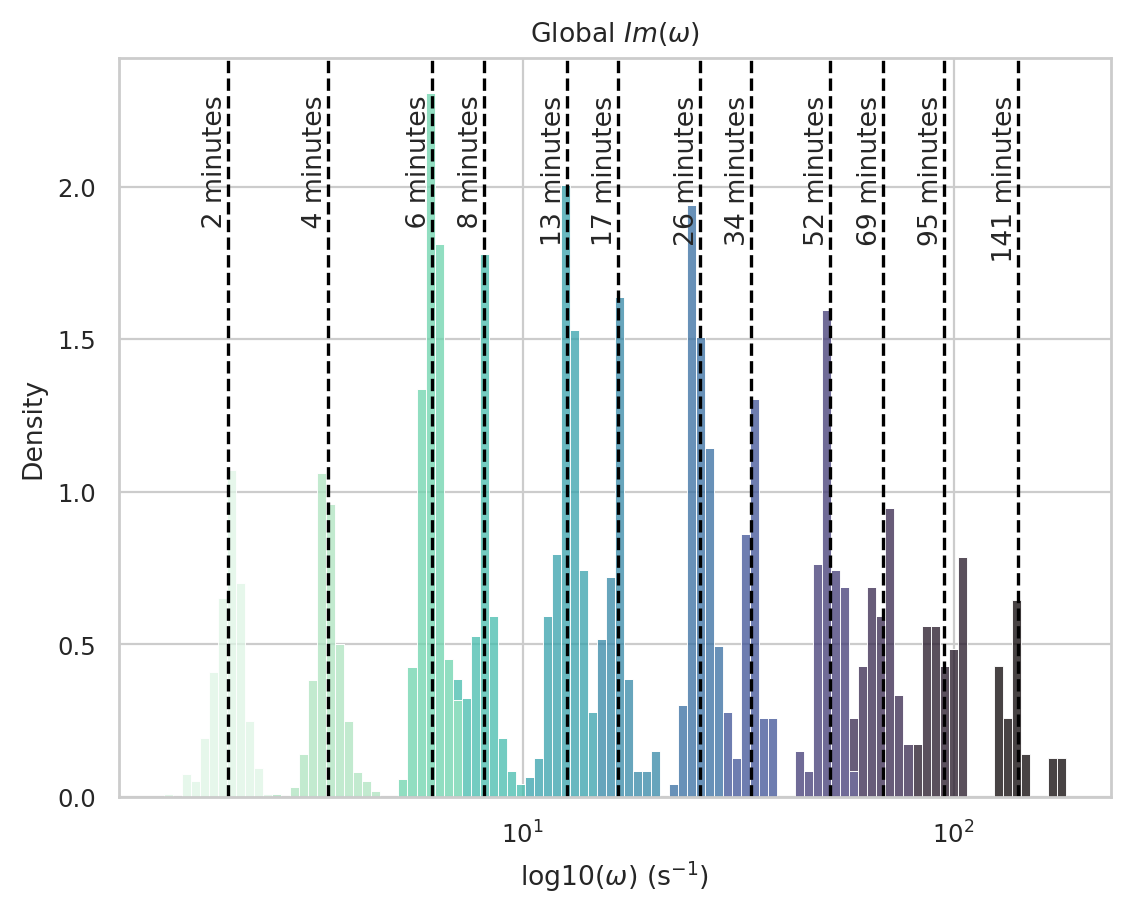

In [19]:
hue_order = np.arange(len(np.unique(omega_classes))).astype(str)

# Convert the centroids to periods in units of minutes
cluster_centers_periods = 1 / (10 ** (cluster_centroids) / (2 * np.pi) * 2)

sns.histplot(
    x=2 * np.pi / (10**omega_array) / 2,
    hue=omega_classes,
    hue_order=hue_order,
    common_bins=True,
    common_norm=True,
    stat="density",
    multiple="stack",
    bins=100,
    palette="mako",
    legend=False,
    log_scale=True,
)

ax = plt.gca()
ax.set_title("Global $Im(\omega)$")
ax.set_xlabel(r"log10($\omega$) (s$^{-1}$)")
[ax.axvline(c, color="k", ls="--") for nc, c in enumerate(cluster_centers_periods)]
y_lim_bottom, y_lim_top = ax.get_ylim()
[
    ax.text(
        c,
        y_lim_top - y_lim_top * 0.05,
        "{:4.0f} minutes".format(c),
        rotation="vertical",
        va="top",
        ha="right",
    )
    for c in cluster_centers_periods
];

# Prepare for analysis

## Scale separated reconstructions

In [20]:
omega_classes_list = mrc.multi_res_deterp()
xr_sep = mrc.global_scale_reconstruction()
xr_background = mrc.get_background()
xr_global = xr_sep.sum(axis=(0, 1)) + xr_background

## Unstack mrCOSTS results

The data consist of a $u$ and $v$ wind component. We stacked those into a single dimension for fitting mrCOSTS but need to unstack those into separate variables for plotting and analysis.

In [21]:
xr_sep_u, xr_sep_v = np.split(xr_sep, indices_or_sections=2, axis=2)
xr_background_u, xr_background_v = np.split(
    xr_background, indices_or_sections=2, axis=0
)
xr_global_u, xr_global_v = np.split(xr_global, indices_or_sections=2, axis=0)

Next we need to convert the data into a `longitude` by `latitude` shape and derive the mean horizontal wind speed and direction.

In [22]:
ds_background_u = xarray_unstacked(
    xr_background_u,
    ds_obs.time.values,
    longitudes_ragged,
    latitudes_ragged,
)
ds_background_u.name = "u_component"

ds_background_v = xarray_unstacked(
    xr_background_v,
    ds_obs.time.values,
    longitudes_ragged,
    latitudes_ragged,
)
ds_background_v.name = "v_component"

ds_background = xr.merge([ds_background_u, ds_background_v])
ds_background["mean_horiz"] = np.sqrt(ds_background_u**2 + ds_background_v**2)
ds_background["phi"] = np.arctan2(ds_background_v, ds_background_u)

In [23]:
ds_global_u = xarray_unstacked(
    xr_global_u,
    ds_obs.time.values,
    longitudes_ragged,
    latitudes_ragged,
)
ds_global_u.name = "u_component"
ds_global_v = xarray_unstacked(
    xr_global_v,
    ds_obs.time.values,
    longitudes_ragged,
    latitudes_ragged,
)
ds_global_v.name = "v_component"

ds_global = xr.merge([ds_global_u, ds_global_v])
ds_global["mean_horiz"] = np.sqrt(ds_global_u**2 + ds_global_v**2)
ds_global["phi"] = np.arctan2(ds_global_v, ds_global_u)

In [24]:
def build_uv_dataset(x_u, x_v, band_num, times, ragged_lon, ragged_lat):
    ds_u = xarray_unstacked(
        x_u[:, ncl_center, :, :].sum(axis=0).squeeze(),
        times,
        ragged_lon,
        ragged_lat,
    )
    ds_u.name = "u_component"

    ds_v = xarray_unstacked(
        x_v[:, ncl_center, :, :].sum(axis=0).squeeze(),
        ds_obs.time.values,
        ragged_lon,
        ragged_lat,
    )
    ds_v.name = "v_component"

    ds_result = xr.merge([ds_u, ds_v])

    ds_result["mean_horiz"] = np.sqrt(ds_u**2 + ds_v**2)
    ds_result["phi"] = np.arctan2(ds_v, ds_u)

    return ds_result

In [25]:
ds_result_dict = {}

for ncl_center, cl_center in enumerate(cluster_centers_periods):
    # Reconstruction
    ds_result_dict[ncl_center] = build_uv_dataset(
        xr_sep_u,
        xr_sep_v,
        ncl_center,
        ds_obs.time.values,
        longitudes_ragged,
        latitudes_ragged,
    )

## Plot times

In [26]:
t1 = "2022-08-12 22:35"
t2 = "2022-08-12 23:20"
t3 = "2022-08-13 03:10"

## Coordinate rotation

Rotate the $u$ and $v$ components into a system that is along and across the main Inn Valley.

In [27]:
def _angle_transform(x, y, alpha):
    trans_x = x * np.cos(alpha) + y * np.sin(alpha)
    trans_y = -x * np.sin(alpha) + y * np.cos(alpha)
    return trans_x, trans_y

### Determine the angle of rotation

Text(11.5875, 47.3, '')

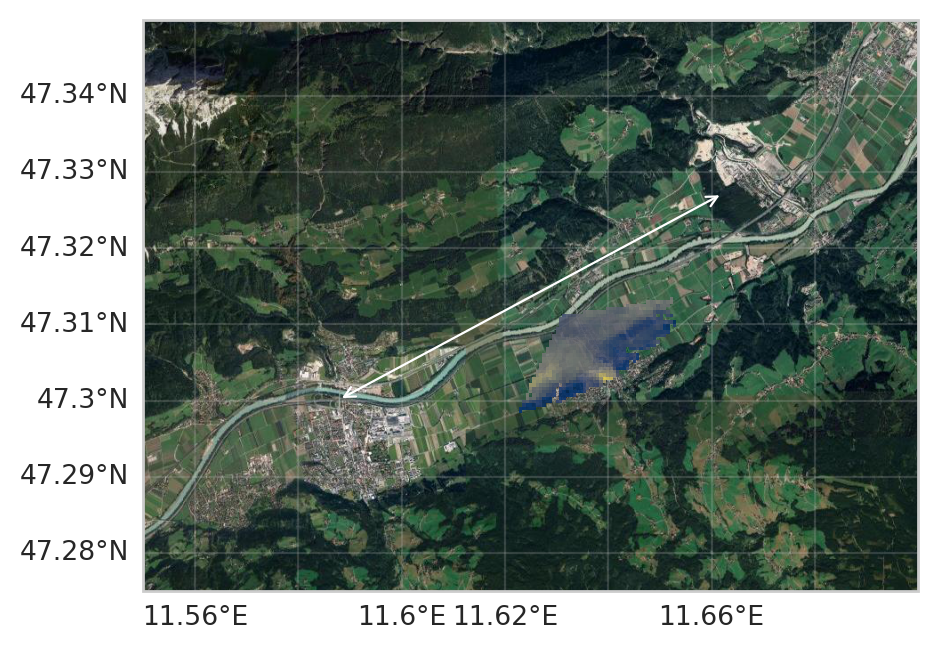

In [28]:
ds_test = ds_global.sel(time="2022-08-13 01:00")

request = cimgt.GoogleTiles(style="satellite")

fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection=request.crs)
# Google tiles
extent = [11.55, 11.7, 47.275, 47.35]
ax.set_extent(extent)
zoom_level = 13
ax.add_image(request, zoom_level)

gl = ax.gridlines(draw_labels=True, alpha=0.2)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False

crs0 = ccrs.PlateCarree(central_longitude=0)

pcm = ax.pcolormesh(
    ds_test.longitude.values,
    ds_test.latitude.values,
    ds_test.mean_horiz.values,
    cmap="cividis",
    vmin=0,
    vmax=2.5,
    zorder=100,
    transform=crs0,
    alpha=0.85,
)
alpha = 20 * np.pi / 180
xlen = (extent[1] - extent[0]) / 2
ax.annotate(
    "",
    xytext=(extent[0] + xlen / 2, extent[2] + (extent[3] - extent[2]) / 3),
    xy=(
        xlen / 2 + xlen + extent[0],
        np.tan(alpha) * xlen + extent[2] + (extent[3] - extent[2]) / 3,
    ),
    xycoords=crs0,
    arrowprops=dict(arrowstyle="<->", color="w"),
    zorder=1000,
)

### Verify

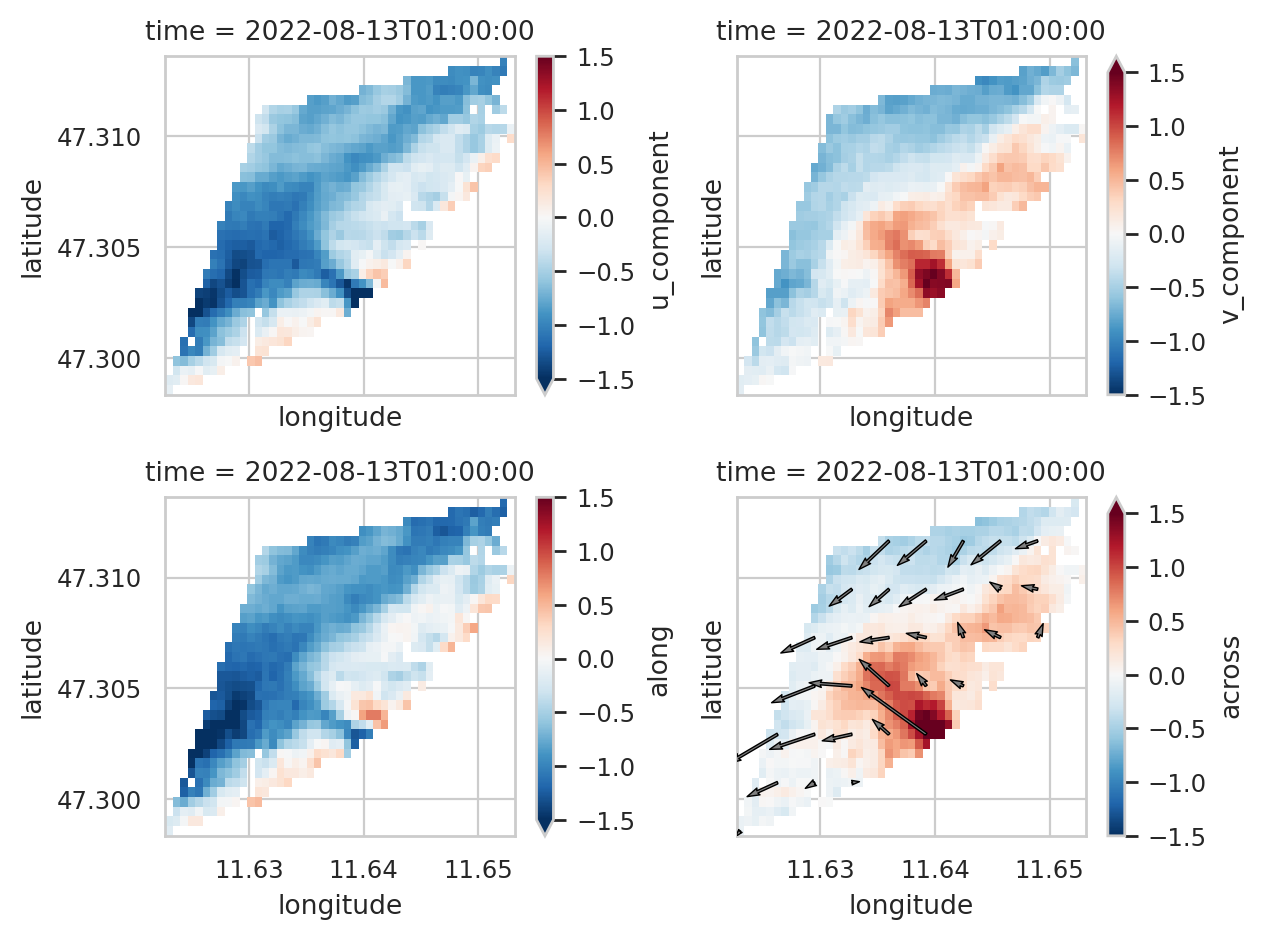

In [29]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
axes = axes.flatten()
ds_test = ds_global.sel(time="2022-08-13 01:00")

quiver_stride = 5

alpha = 20 * np.pi / 180
along, across = _angle_transform(ds_test.u_component, ds_test.v_component, alpha)
ds_test["along"] = (("latitude", "longitude"), along.values)
ds_test["across"] = (("latitude", "longitude"), across.values)

ds_test.u_component.plot(ax=axes[0], cmap="RdBu_r", vmin=-1.5, vmax=1.5)
ds_test.v_component.plot(ax=axes[1], cmap="RdBu_r", vmin=-1.5, vmax=1.5)

ds_test.along.plot(ax=axes[2], cmap="RdBu_r", vmin=-1.5, vmax=1.5)
ds_test.across.plot(ax=axes[3], cmap="RdBu_r", vmin=-1.5, vmax=1.5)

quiv = axes[-1].quiver(
    ds_test.longitude[::quiver_stride],
    ds_test.latitude[::quiver_stride],
    ds_test["u_component"].values[::quiver_stride, ::quiver_stride],
    ds_test["v_component"].values[::quiver_stride, ::quiver_stride],
    scale=10,
    zorder=101,
    facecolor="0.5",
    edgecolor="k",
    linewidth=0.5,
)

plt.tight_layout()

### Add to datasets

In [30]:
ds_global_results = xr.concat(
    ds_result_dict.values(),
    pd.Index(np.arange(mrc.n_components_global), name="cluster"),
)
ds_global_results.coords["cluster_periods"] = (("cluster"), cluster_centers_periods)
ds_global_results

<xarray.Dataset>
Dimensions:          (time: 338, latitude: 35, longitude: 47, cluster: 12)
Coordinates:
  * time             (time) datetime64[ns] 2022-08-12T20:00:00 ... 2022-08-13...
  * latitude         (latitude) float64 47.3 47.3 47.3 ... 47.31 47.31 47.31
  * longitude        (longitude) float64 11.62 11.62 11.62 ... 11.65 11.65 11.65
  * cluster          (cluster) int64 0 1 2 3 4 5 6 7 8 9 10 11
    cluster_periods  (cluster) float64 140.7 95.22 68.5 ... 6.143 3.524 2.066
Data variables:
    u_component      (cluster, time, latitude, longitude) float64 -0.1549 ......
    v_component      (cluster, time, latitude, longitude) float64 -0.02357 .....
    mean_horiz       (cluster, time, latitude, longitude) float64 0.1566 ... nan
    phi              (cluster, time, latitude, longitude) float64 -2.991 ... nan

In [31]:
alpha = 20 * np.pi / 180
along, across = _angle_transform(
    ds_global_results.u_component, ds_global_results.v_component, alpha
)
ds_global_results["along"] = (("cluster", "time", "latitude", "longitude"), along.data)
ds_global_results["across"] = (
    ("cluster", "time", "latitude", "longitude"),
    across.values,
)

along, across = _angle_transform(
    ds_background.u_component, ds_background.v_component, alpha
)
ds_background["along"] = (("time", "latitude", "longitude"), along.data)
ds_background["across"] = (("time", "latitude", "longitude"), across.values)

along, across = _angle_transform(ds_obs.u_component, ds_obs.v_component, alpha)
ds_obs["along"] = (("time", "latitude", "longitude"), along.data)
ds_obs["across"] = (("time", "latitude", "longitude"), across.values)

# Evaluation of mrCOSTS fit

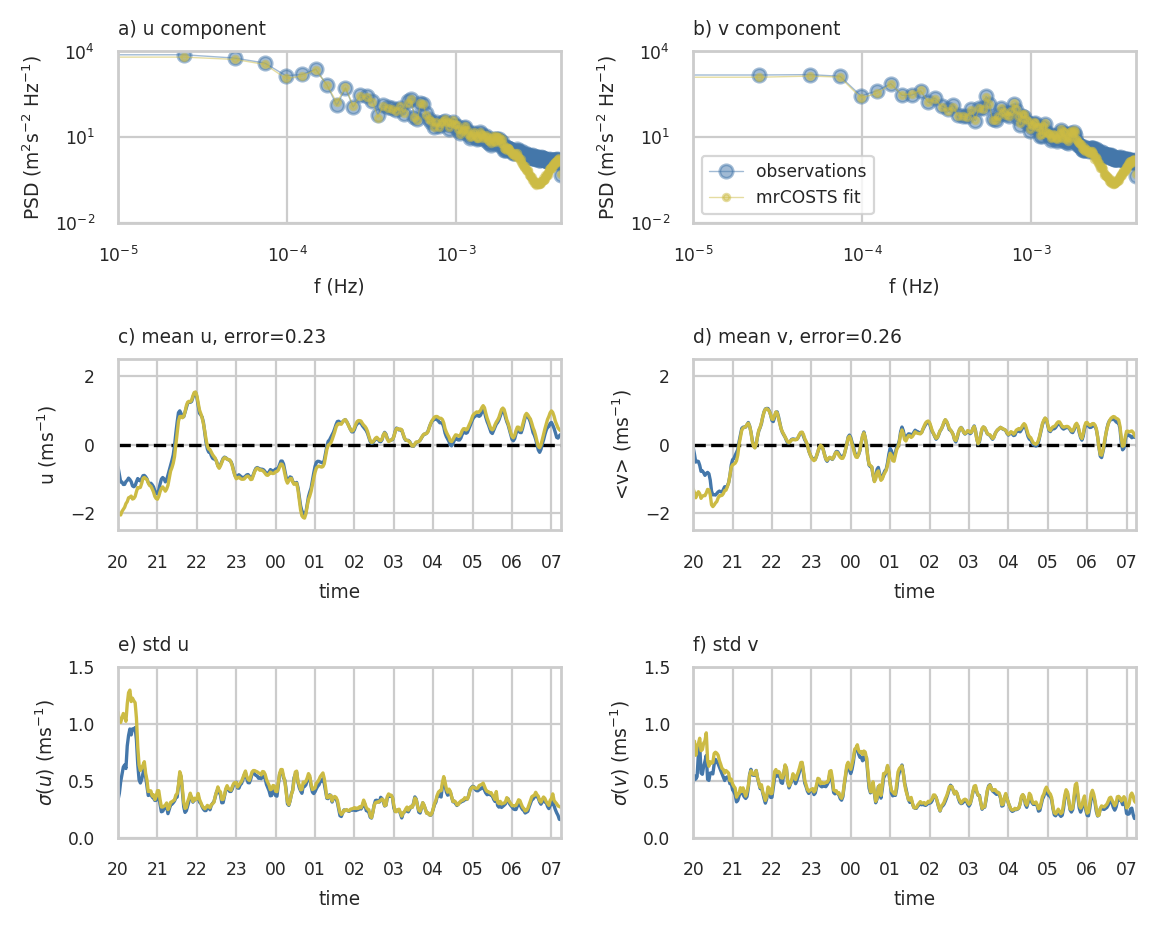

In [32]:
with (
    sns.axes_style("whitegrid"),
    sns.plotting_context("paper", font_scale=0.7),
    sns.color_palette(sns.color_palette(tol_bright_reorder)),
):

    cm = 1 / 2.54  # centimeters in inches
    fig, axes = plt.subplots(3, 2, figsize=(15 * cm, 12 * cm))
    date_format = DateFormatter("%H")

    paired_color_hexes = [
        "#a6cee3",
        "#1f78b4",
        "#b2df8a",
        "#33a02c",
    ]
    paired_color_palette = sns.color_palette(paired_color_hexes)

    ax = axes[0, 0]
    fs = 1 / (np.diff(ts)[0] * 60)
    f, Pxx_den = signal_processing.welch(data_1d_u, fs, nperseg=1024, average="median")
    ax.loglog(
        f,
        np.median(Pxx_den, axis=0),
        color=tol_bright_reorder[0],
        lw=0.5,
        marker="o",
        alpha=0.5,
    )
    f, Pxx_den = signal_processing.welch(
        xr_global_u, fs, nperseg=1024, average="median"
    )
    ax.loglog(
        f,
        np.median(Pxx_den, axis=0),
        color=tol_bright_reorder[1],
        lw=0.5,
        marker=".",
        alpha=0.5,
    )

    ax.set_ylabel(r"PSD (m$^2$s$^{-2}$ Hz$^{-1}$)")
    ax.set_title("a) u component", loc="left")
    ax.set_ylim(10**-2, 10**4)
    ax.set_xlim(10**-5, f.max())
    ax.set_xlabel("f (Hz)")

    ax = axes[0, 1]
    f, Pxx_den = signal_processing.welch(data_1d_v, fs, nperseg=1024, average="median")
    ax.loglog(
        f,
        np.median(Pxx_den, axis=0),
        color=tol_bright_reorder[0],
        lw=0.5,
        marker="o",
        alpha=0.5,
        label="observations",
    )
    f, Pxx_den = signal_processing.welch(
        xr_global_v, fs, nperseg=1024, average="median"
    )
    ax.loglog(
        f,
        np.median(Pxx_den, axis=0),
        color=tol_bright_reorder[1],
        lw=0.5,
        marker=".",
        alpha=0.5,
        label="mrCOSTS fit",
    )
    ax.set_ylabel(r"PSD (m$^2$s$^{-2}$ Hz$^{-1}$)")
    ax.set_title("b) v component", loc="left")
    ax.set_xlabel("f (Hz)")
    ax.legend()
    ax.set_ylim(10**-2, 10**4)
    ax.set_xlim(10**-5, f.max())

    ax = axes[1, 0]
    ax.axhline(0, ls="--", color="k")
    ax.plot(
        ds_global.time,
        ds_global.u_component.mean(dim=["longitude", "latitude"]),
        color=tol_bright_reorder[0],
    )
    ax.plot(
        ds_obs.time,
        ds_obs.u_component.mean(dim=["longitude", "latitude"]),
        color=tol_bright_reorder[1],
    )
    ax.set_ylabel("u (ms$^{-1}$)")
    ax.set_ylim(-2.5, 2.5)
    ax.xaxis.set_major_formatter(date_format)
    error = mrc.costs_array[0].relative_error(xr_global_u, data_1d_u)
    ax.set_title(f"c) mean u, error={error:.2f}", loc="left")
    ax.set_xlabel("time")
    ax.set_xlim(ds_obs.time[0].values, ds_obs.time[-1].values)

    ax = axes[1, 1]
    ax.axhline(0, ls="--", color="k")
    ax.plot(
        ds_global.time,
        ds_global.v_component.mean(dim=["longitude", "latitude"]),
        color=tol_bright_reorder[0],
    )
    ax.plot(
        ds_obs.time,
        ds_obs.v_component.mean(dim=["longitude", "latitude"]),
        color=tol_bright_reorder[1],
    )
    ax.set_ylabel("<v> (ms$^{-1}$)")
    ax.set_ylim(-2.5, 2.5)
    error = mrc.costs_array[0].relative_error(xr_global_v, data_1d_v)
    ax.set_title(f"d) mean v, error={error:.2f}", loc="left")
    ax.xaxis.set_major_formatter(date_format)
    ax.set_xlabel("time")
    ax.set_xlim(ds_obs.time[0].values, ds_obs.time[-1].values)

    ax = axes[2, 0]
    ax.plot(
        ds_global.time,
        ds_global.u_component.std(dim=["longitude", "latitude"]),
        color=tol_bright_reorder[0],
    )
    ax.plot(
        ds_obs.time,
        ds_obs.u_component.std(dim=["longitude", "latitude"]),
        color=tol_bright_reorder[1],
    )
    ax.set_ylabel("$\sigma(u)$ (ms$^{-1}$)")
    ax.set_ylim(0, 1.5)
    ax.set_title(f"e) std u", loc="left")
    ax.xaxis.set_major_formatter(date_format)
    ax.set_xlabel("time")
    ax.set_xlim(ds_obs.time[0].values, ds_obs.time[-1].values)

    ax = axes[2, 1]
    ax.plot(
        ds_global.time,
        ds_global.v_component.std(dim=["longitude", "latitude"]),
        color=tol_bright_reorder[0],
    )
    ax.plot(
        ds_obs.time,
        ds_obs.v_component.std(dim=["longitude", "latitude"]),
        color=tol_bright_reorder[1],
    )
    ax.set_ylabel("$\sigma(v)$ (ms$^{-1}$)")
    ax.set_ylim(0, 1.5)
    ax.set_title(f"f) std v", loc="left")
    ax.xaxis.set_major_formatter(date_format)
    ax.set_xlabel("time")
    ax.set_xlim(ds_obs.time[0].values, ds_obs.time[-1].values)

plt.tight_layout()

os.chdir(dir_print)
fig.savefig(f"MoBL.PNAS-fit-evalution.{strategy}.pdf", dpi=300, bbox_inches="tight")

In [33]:
print("u component")
error = mrc.costs_array[0].relative_error(xr_global_u, data_1d_u)
print(f"Error for the full time = {error:.2f}")

error = mrc.costs_array[0].relative_error(xr_global_u[:, 10:-10], data_1d_u[:, 10:-10])
print(f"Error excluding the first and last 20 minutes = {error:.2f}")

u component
Error for the full time = 0.23
Error excluding the first and last 20 minutes = 0.14


In [34]:
print("v component")
error = mrc.costs_array[0].relative_error(xr_global_v, data_1d_v)
print(f"Error for the full time = {error:.2f}")

error = mrc.costs_array[0].relative_error(xr_global_v[:, 10:-10], data_1d_v[:, 10:-10])
print(f"Error excluding the first and last 20 minutes = {error:.2f}")

v component
Error for the full time = 0.26
Error excluding the first and last 20 minutes = 0.15


In [35]:
recon_horiz = ds_global.mean_horiz.values
recon_horiz = recon_horiz.flatten()[np.flatnonzero(~np.isnan(recon_horiz))]

obs_horiz = ds_obs.mean_horiz.values
obs_horiz = obs_horiz.flatten()[np.flatnonzero(~np.isnan(obs_horiz))]

In [36]:
recon_horiz = np.sqrt(xr_global_u**2 + xr_global_v**2)
obs_horiz = np.sqrt(data_1d_u**2 + data_1d_v**2)

print("mean U")
error = mrc.costs_array[0].relative_error(obs_horiz, recon_horiz)
print(f"Error for the full time = {error:.2f}")

error = mrc.costs_array[0].relative_error(obs_horiz[:, 10:-10], recon_horiz[:, 10:-10])
print(f"Error excluding the first and last 20 minutes = {error:.2f}")

mean U
Error for the full time = 0.26
Error excluding the first and last 20 minutes = 0.14


# PNAS Figures

Notes:

Clarify what the seiche reflects on (bend in valley creating virtual boundary, density boundaries between tributaroy outlfows). The waves _appear_ to be standing but the scale of these waves is unclear given their time scale and spatial scale being larger than the LIDAR footprint.

Gravity waves generally are not explored in these horizontal scales.

Limited seiche papers, possibly due to the difficulty analyzing these kinds of processes without a method like mrCOSTS.

Large scale forcing (inflow from pre-alpine region) creates dynamic perturbations to the valley wind system, potentially acting as a mechanism. Alternatively trapped gravity waves at upper levels could create pressure minima and maxima which could generate a local flow. All these effects could be combined of course as well. However, these forcings would be quasi-stationary and likely could not generate the oscillatons but explain the anamolous up-valley flow in the evening.

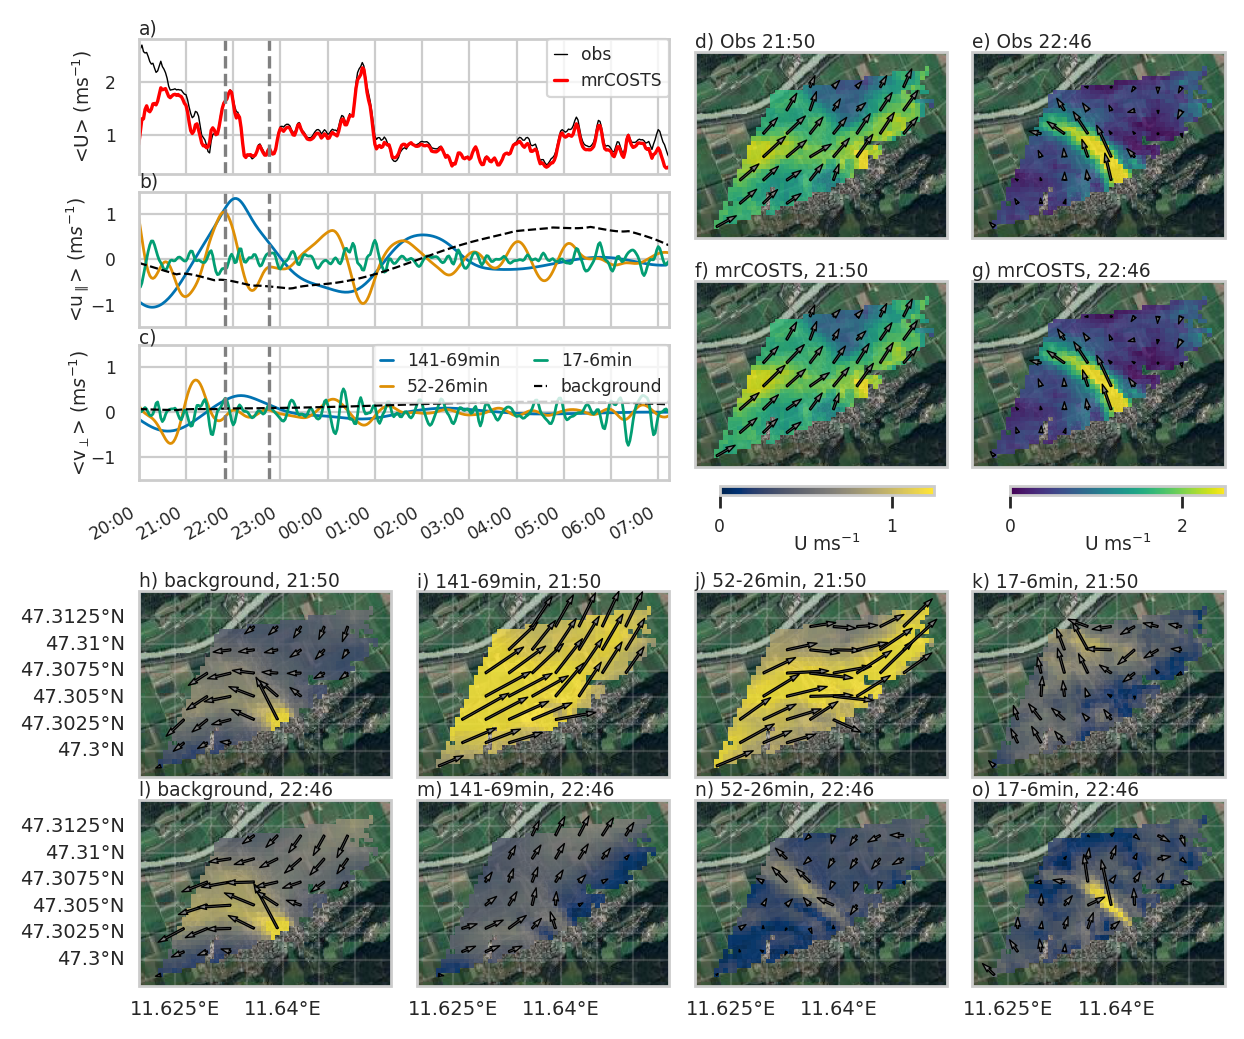

In [37]:
with (
    sns.axes_style("whitegrid"),
    sns.plotting_context("paper", font_scale=0.7),
):

    # ----------------------------------------------------------------------------
    # Set up
    t1 = "2022-08-12 21:50"
    t2 = "2022-08-12 22:46"
    times_to_plot = [t1, t2]
    bands_to_plot = [[0, 1, 2], [3, 4, 5], [6, 7, 8, 9]]

    cm = 1 / 2.54  # centimeters in inches
    request = cimgt.GoogleTiles(style="satellite")
    cartopy_kws = dict(projection=request.crs)
    fig = plt.figure(figsize=(17.8 * cm, 16 * cm))

    ncols = 4

    gs = gridspec.GridSpec(2, 1, figure=fig)
    gs_top = gs[0].subgridspec(6, 4, wspace=0.1, hspace=0.3)
    gs_bot = gs[1].subgridspec(2, ncols, wspace=0.1, hspace=-0.1)

    axes_recon = []
    axes_obs = []
    for n in range(2):
        axes_obs.append(fig.add_subplot(gs_top[0:3, n + 2], **cartopy_kws))
    for n in range(2):
        axes_recon.append(fig.add_subplot(gs_top[3:, n + 2], **cartopy_kws))

    axes_time_series = []
    axes_time_series.append(fig.add_subplot(gs_top[0:2, :2]))
    axes_time_series.append(fig.add_subplot(gs_top[2:4, :2]))
    axes_time_series.append(fig.add_subplot(gs_top[4:, :2]))

    axes_bands = []
    for nrow in range(2):
        for ncol in range(ncols):
            axes_bands.append(fig.add_subplot(gs_bot[nrow, ncol], **cartopy_kws))

    request = cimgt.GoogleTiles(style="satellite")
    zoom_level = 13
    extent = [11.62, 11.655, 47.2975, 47.315]

    vmin = 0
    vmax_global = 2.5
    cmap_global = "viridis"
    scale_global = 20

    vmax_local = 1.25
    cmap_local = "cividis"
    scale_local = 7.5

    # ----------------------------------------------------------------------------
    # Observations and reconstruction of full wind field
    for nt, t in enumerate(times_to_plot):
        str_time = pd.Timestamp(t).strftime("%H:%M")
        title = f"{alphabet[nt + 3]}) Obs {str_time}"

        ds_plot = ds_obs.sel(time=t, method="nearest")
        ax = axes_obs[nt]
        pcolor_quiver_plotter(
            ds_plot,
            ax,
            extent,
            request,
            crs0,
            vmin,
            vmax_global,
            title,
            cmap_global,
            scale=20,
            quiver_stride=quiver_stride,
            label_grid=False,
        )

        ds_plot = ds_global.sel(time=t, method="nearest")
        title = f"{alphabet[nt + len(times_to_plot) + 3]}) mrCOSTS, {str_time}"
        ax = axes_recon[nt]
        pcolor_quiver_plotter(
            ds_plot,
            ax,
            extent,
            request,
            crs0,
            vmin,
            vmax_global,
            title,
            cmap_global,
            scale=20,
            quiver_stride=quiver_stride,
            label_grid=False,
        )

    # ----------------------------------------------------------------------------
    # Time series
    palette = sns.color_palette("colorblind", len(bands_to_plot))

    ax = axes_time_series[0]
    ground_truth = ds_obs.mean_horiz.mean(dim=["longitude", "latitude"])
    ground_truth.plot(ax=ax, color="k", lw=0.5, label="obs")

    ds_global.mean_horiz.mean(dim=["longitude", "latitude"]).plot(
        label="mrCOSTS", color="r", ax=ax
    )
    ax.set_title(f"{alphabet[0]})", loc="left", pad=0.35)
    ax.legend(
        loc="upper right", handlelength=0.75, bbox_to_anchor=(1, 1), borderaxespad=0
    )
    ax.set_ylabel("<U> (ms$^{-1}$)")
    ax.set_xlabel("")
    ax.set_xticklabels("")
    ax.set_xlim(ds_global.time[0], ds_global.time[-1])

    for nt, t in enumerate(times_to_plot):
        ax.axvline(pd.Timestamp(t), color="0.5", ls="--")

    ax_u = axes_time_series[1]
    ax_v = axes_time_series[2]
    for nband, bands in enumerate(bands_to_plot):
        clusters_to_plot = [cluster_centers_periods[b] for b in bands]
        ds_plot = ds_global_results.sel(cluster=bands).sum(dim="cluster", min_count=1)
        ds_plot["mean_horiz"] = np.sqrt(ds_plot.u_component**2 + ds_plot.v_component**2)
        label = "{:.0f}-{:.0f}min".format(
            cluster_centers_periods[bands[0]], cluster_centers_periods[bands[-1]]
        )
        alpha = 20 * np.pi / 180
        along, across = _angle_transform(
            ds_plot.u_component, ds_plot.v_component, alpha
        )
        ds_plot["along"] = (("time", "latitude", "longitude"), along.data)
        ds_plot["across"] = (("time", "latitude", "longitude"), across.values)

        ds_plot.along.mean(dim=["longitude", "latitude"]).plot(
            ax=ax_u, label=label, lw=1, color=palette[nband]
        )
        ds_plot.across.mean(dim=["longitude", "latitude"]).plot(
            ax=ax_v, label=label, lw=1, color=palette[nband]
        )

    alpha = 20 * np.pi / 180
    along, across = _angle_transform(
        ds_background.u_component, ds_background.v_component, alpha
    )
    ds_background["along"] = (("time", "latitude", "longitude"), along.data)
    ds_background["across"] = (("time", "latitude", "longitude"), across.values)

    ds_background.along.mean(dim=["longitude", "latitude"]).plot(
        label="background",
        color="k",
        lw=0.8,
        ls="--",
        ax=ax_u,
    )
    ax_u.set_title(f"{alphabet[1]})", loc="left", pad=0.35)
    ax_u.set_xlim(ds_plot.time[0], ds_plot.time[-1])
    ax_u.set_ylabel("<u$_{\parallel}$> (m$s^{-1}$)", labelpad=-0.5)
    ax_u.set_xlabel("")
    ax_u.xaxis.set_major_formatter(DateFormatter("%H:%M"))
    ax_u.set_ylim(-1.5, 1.5)
    ax_u.set_xticklabels("")
    for nt, t in enumerate(times_to_plot):
        ax_u.axvline(pd.Timestamp(t), color="0.5", ls="--")

    ds_background.across.mean(dim=["longitude", "latitude"]).plot(
        label="background",
        color="k",
        lw=0.8,
        ls="--",
        ax=ax_v,
    )
    ax_v.legend(
        loc="upper right",
        ncols=2,
        handlelength=0.75,
        bbox_to_anchor=(1, 1),
        borderaxespad=0,
    )
    ax_v.set_title(f"{alphabet[2]})", loc="left", pad=0.35)
    ax_v.set_xlim(ds_plot.time[0], ds_plot.time[-1])
    ax_v.set_ylabel("<v$_{\perp}$> (m$s^{-1}$)", labelpad=-0.5)
    ax_v.set_xlabel("")
    ax_v.xaxis.set_major_formatter(DateFormatter("%H:%M"))
    ax_v.set_ylim(-1.5, 1.5)
    for nt, t in enumerate(times_to_plot):
        ax_v.axvline(pd.Timestamp(t), color="0.5", ls="--")

    # ----------------------------------------------------------------------------
    # Combined components
    for ntime, t in enumerate(times_to_plot):
        str_time = pd.Timestamp(t).strftime("%H:%M")

        ax = axes_bands[ntime * ncols]
        title = f"{alphabet[ntime * ncols + 7]}) background, {str_time}"
        pcolor_quiver_plotter(
            ds_background.sel(time=t, method="nearest"),
            ax,
            extent,
            request,
            crs0,
            0,
            vmax_local,
            title,
            cmap_local,
            quiver_stride=quiver_stride,
            scale=scale_local,
            text=None,
        )

        for nband, bands in enumerate(bands_to_plot):
            ds_plot = ds_global_results.sel(cluster=bands).sum(
                dim="cluster", min_count=1
            )
            ds_plot["mean_horiz"] = np.sqrt(
                ds_plot.u_component**2 + ds_plot.v_component**2
            )
            ds_plot["phi"] = np.arctan2(ds_plot.v_component, ds_plot.u_component)
            axes_number = nband + 1 + (ntime) * ncols
            ax = axes_bands[axes_number]

            label = "{:.0f}-{:.0f}min".format(
                cluster_centers_periods[bands[0]], cluster_centers_periods[bands[-1]]
            )

            title = f"{alphabet[axes_number + 7]}) {label}, {str_time}"

            pcolor_quiver_plotter(
                ds_plot.sel(time=t, method="nearest"),
                ax,
                extent,
                request,
                crs0,
                0,
                vmax_local,
                title,
                cmap_local,
                quiver_stride=quiver_stride,
                scale=scale_local,
                text=None,
            )

    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax_local)
    cax = axes_recon[-1].inset_axes([-1, -0.15, 0.85, 0.05])
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap_local),
        cax=cax,
        orientation="horizontal",
    )
    cbar.set_label(r"U ms$^{-1}$", labelpad=-1)

    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax_global)
    cax = axes_recon[-1].inset_axes([0.15, -0.15, 0.85, 0.05])
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap_global),
        cax=cax,
        orientation="horizontal",
    )
    cbar.set_label(r"U ms$^{-1}$", labelpad=-1)

    os.chdir(dir_print)
    fig.savefig(
        "KIT-cube_mrCOSTS-overview_along-across.v2.png", dpi=300, bbox_inches="tight"
    )
    fig.savefig("KIT-cube_mrCOSTS-overview_along-across.v2.jpg", bbox_inches="tight")
    fig.savefig("KIT-cube_mrCOSTS-overview_along-across.v2.pdf", bbox_inches="tight")